# GeoAI Project: Flood/Water Detection using Sentinel-2 and TensorFlow (U-Net)

### Overview

In this notebook, we will build a semantic segmentation model (U-Net) to detect water vs non-water pixels from Sentinel-2 satellite images.

We will:

Prepare and preprocess Sentinel-2 image tiles and binary masks.

Build a U-Net model using TensorFlow/Keras.

Train and evaluate the model.

Visualize predictions and overlays.

Save the trained model for later deployment.

In [16]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU is available:", gpus)
else:
    print("⚠️ Using CPU (no GPU detected).")


TensorFlow version: 2.19.0
✅ GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!nvidia-smi

Thu Nov 13 10:32:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import Required Libraries

In [3]:
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm


### Dataset Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
DATA_DIR = "/content/drive/MyDrive/Tenserflow/Water Bodies Dataset"
images_dir = os.path.join(DATA_DIR, "Images")
masks_dir  = os.path.join(DATA_DIR, "Binary_Masks")

## Preprocessing (Convert Masks to Binary)

In [ ]:
os.makedirs(masks_dir, exist_ok=True)
mask_dir = os.path.join(DATA_DIR, "Masks")

mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.jpg")))
print("Total masks found:", len(mask_paths))

for mask_path in tqdm(mask_paths, desc="Converting to binary masks"):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 128, 1, cv2.THRESH_BINARY)
    save_path = os.path.join(masks_dir, os.path.basename(mask_path))
    cv2.imwrite(save_path, binary * 255)

print("✅ All masks converted and saved to:", masks_dir)


Total masks found: 2841


Converting to binary masks: 100%|██████████| 2841/2841 [32:40<00:00,  1.45it/s]

✅ All masks converted and saved to: /content/drive/MyDrive/GeoAI/Tenserflow/Water Bodies Dataset/Binary_Masks


## Verify Dataset and Split

In [6]:
image_files = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
mask_files  = sorted(glob.glob(os.path.join(masks_dir, "*.jpg")))

pairs = [(i, m) for i, m in zip(image_files, mask_files) if os.path.basename(i) == os.path.basename(m)]

print(f"✅ Total paired samples: {len(pairs)}")

train_pairs, test_pairs = train_test_split(pairs, test_size=0.1, random_state=42)
train_pairs, val_pairs  = train_test_split(train_pairs, test_size=0.1, random_state=42)

print(f"Train samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")
print(f"Test samples: {len(test_pairs)}")


✅ Total paired samples: 2841
Train samples: 2300
Validation samples: 256
Test samples: 285


# TensorFlow Data Pipeline

## Preprocessing Function

In [7]:
IMG_HEIGHT, IMG_WIDTH = 256, 256

def preprocess_image_mask(image_path, mask_path, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    mask = np.where(mask > 127, 1, 0).astype(np.float32)

    return img, np.expand_dims(mask, axis=-1)


## TensorFlow Dataset Loader

In [8]:
def load_and_preprocess(image_path, mask_path):
    img, mask = tf.numpy_function(
        func=preprocess_image_mask,
        inp=[image_path, mask_path],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    return img, mask

def make_dataset(pairs, batch_size=8, shuffle=True):
    image_paths = [i for i, _ in pairs]
    mask_paths  = [m for _, m in pairs]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

BATCH_SIZE = 8
train_ds = make_dataset(train_pairs, BATCH_SIZE)
val_ds   = make_dataset(val_pairs, BATCH_SIZE, shuffle=False)
test_ds  = make_dataset(test_pairs, 1, shuffle=False)

print("✅ TensorFlow datasets ready!")


✅ TensorFlow datasets ready!


## Visualize Sample Images and Masks

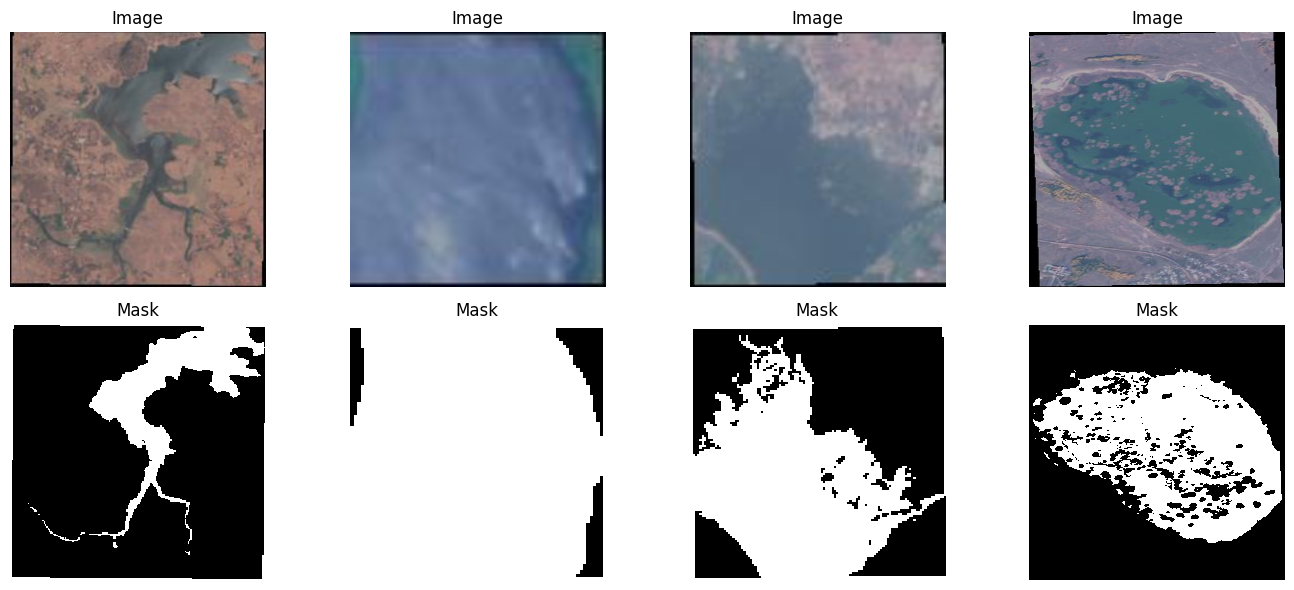

In [ ]:
for imgs, masks in train_ds.take(1):
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    for i in range(4):
        axes[0, i].imshow(imgs[i])
        axes[0, i].set_title("Image")
        axes[0, i].axis("off")
        axes[1, i].imshow(masks[i][:,:,0], cmap="gray")
        axes[1, i].set_title("Mask")
        axes[1, i].axis("off")
    plt.tight_layout()
    plt.show()


## Build U-Net Model

In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Loss Function and Metrics

In [11]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=['accuracy', iou_metric]
)


## Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "/content/drive/MyDrive/GeoAI/Tenserflow/unet_water_best.keras"

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_iou_metric', mode='max', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_iou_metric', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

EPOCHS = 25

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/25
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8039 - iou_metric: 0.5227 - loss: 0.8770
Epoch 1: val_iou_metric improved from -inf to 0.57518, saving model to /content/drive/MyDrive/GeoAI/Tenserflow/unet_water_best.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 144s 486ms/step - accuracy: 0.8039 - iou_metric: 0.5227 - loss: 0.8770 - val_accuracy: 0.8363 - val_iou_metric: 0.5752 - val_loss: 0.7633 - learning_rate: 1.0000e-04
Epoch 2/25
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8427 - iou_metric: 0.5897 - loss: 0.7341
Epoch 2: val_iou_metric improved from 0.57518 to 0.62977, saving model to /content/drive/MyDrive/GeoAI/Tenserflow/unet_water_best.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 138s 470ms/step - accuracy: 0.8427 - iou_metric: 0.5898 - loss: 0.7341 - val_accuracy: 0.8647 - val_iou_metric: 0.6298 - val_loss: 0.6494 - learning_rate: 1.0000e-04
Epoch 3/25
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8639 - iou_metric: 0.6371 - loss: 0.6533
Epoch 3: val_i

In [10]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Tenserflow/unet_water_best.keras",
    custom_objects={
        "dice_loss": lambda y_true, y_pred: 0,  # temporary placeholder, we'll redefine below
        "combined_loss": lambda y_true, y_pred: 0,
        "iou_metric": lambda y_true, y_pred: 0
    }
)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "/content/drive/MyDrive/Tenserflow/unet_water_best.keras"

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_iou_metric', mode='max', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_iou_metric', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

print("✅ Callbacks reinitialized successfully.")


✅ Callbacks reinitialized successfully.


In [13]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=18,   # your last completed epoch
    epochs=25,
    callbacks=callbacks
)


Epoch 19/25
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9210 - iou_metric: 0.7661 - loss: 0.4009
Epoch 19: val_iou_metric improved from -inf to 0.73167, saving model to /content/drive/MyDrive/Tenserflow/unet_water_best.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 1556s 5s/step - accuracy: 0.9210 - iou_metric: 0.7661 - loss: 0.4009 - val_accuracy: 0.9056 - val_iou_metric: 0.7317 - val_loss: 0.4639 - learning_rate: 1.0000e-04
Epoch 20/25
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9259 - iou_metric: 0.7848 - loss: 0.3742
Epoch 20: val_iou_metric improved from 0.73167 to 0.73525, saving model to /content/drive/MyDrive/Tenserflow/unet_water_best.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 162s 551ms/step - accuracy: 0.9259 - iou_metric: 0.7848 - loss: 0.3742 - val_accuracy: 0.9026 - val_iou_metric: 0.7353 - val_loss: 0.4656 - learning_rate: 1.0000e-04
Epoch 21/25
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9251 - iou_metric: 0.7765 - loss: 0.3792
Epoch 21: val_iou_metric d

## Visualize Training Curves

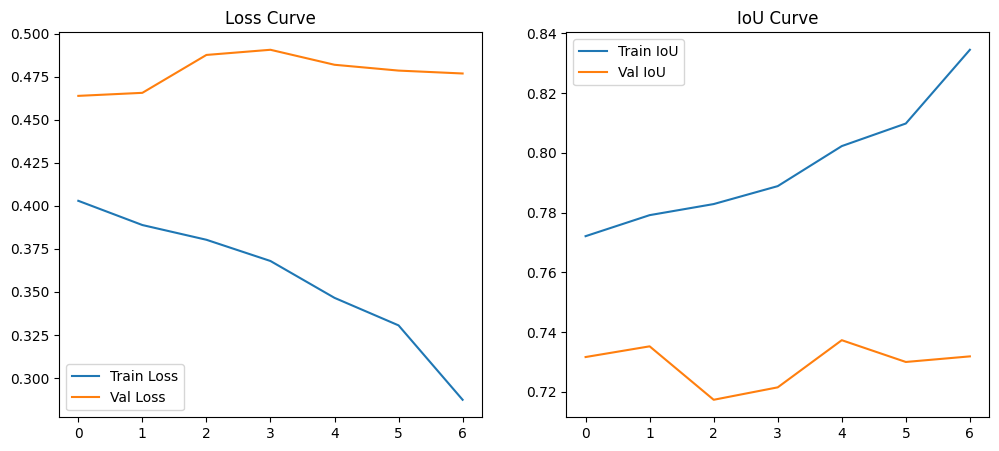

In [17]:
plt.figure(figsize=(12,5))

# --- Loss curve ---
plt.subplot(1,2,1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

# --- IoU curve ---
plt.subplot(1,2,2)
plt.plot(history2.history['iou_metric'], label='Train IoU')
plt.plot(history2.history['val_iou_metric'], label='Val IoU')
plt.legend()
plt.title('IoU Curve')

plt.show()

## Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


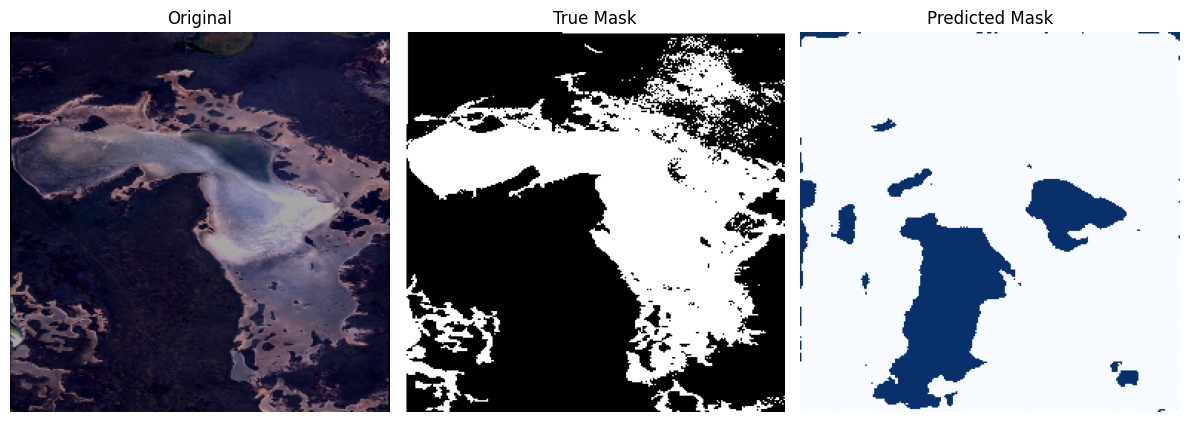

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


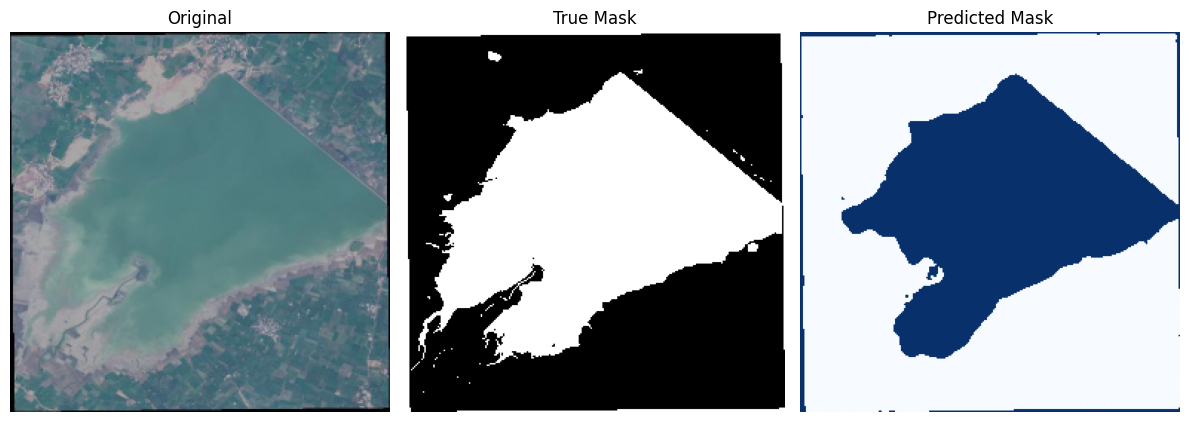

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


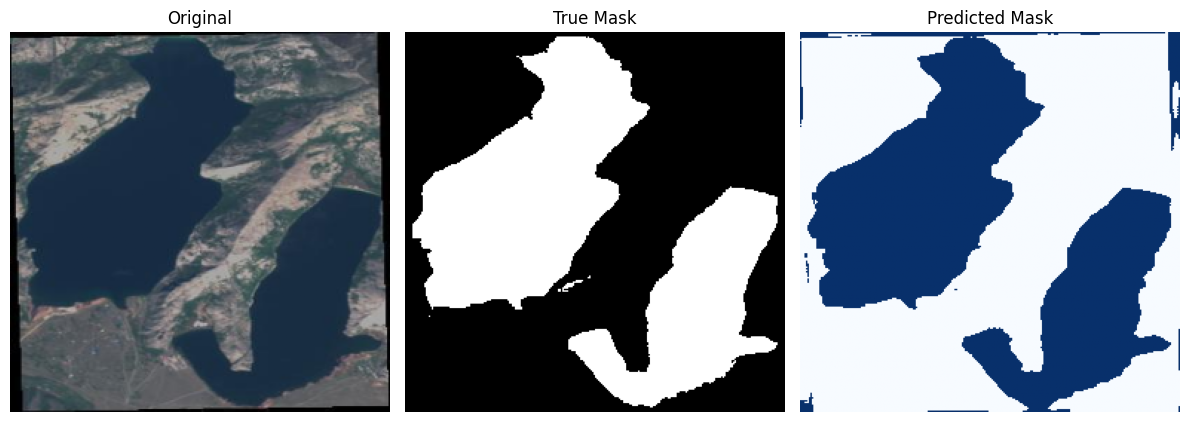

In [18]:
for imgs, masks in test_ds.take(3):
    preds = model.predict(imgs)
    preds = (preds > 0.5).astype(np.uint8)

    for i in range(len(imgs)):
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        axes[0].imshow(imgs[i])
        axes[0].set_title("Original")
        axes[1].imshow(masks[i][:,:,0], cmap='gray')
        axes[1].set_title("True Mask")
        axes[2].imshow(preds[i][:,:,0], cmap='Blues')
        axes[2].set_title("Predicted Mask")
        for ax in axes: ax.axis('off')
        plt.tight_layout()
        plt.show()


## Save the Trained Model

In [22]:
# Save in Keras format
model.save("/content/drive/MyDrive/Tenserflow/unet_water_final.keras")

# Save in TensorFlow SavedModel format
model.export("/content/drive/MyDrive/Tenserflow/unet_water_model")

print("✅ Model saved successfully!")

Saved artifact at '/content/drive/MyDrive/Tenserflow/unet_water_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')]
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  136611255748368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255749328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255749136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255748176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255747024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255750288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255748944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255748560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255751056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136611255750096: TensorSpec(shape=(